In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:90%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:11pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:10pt;padding:5px;}
table.dataframe{font-size:10px;}
</style>
"""))

<b><font size="6" color="red">Ch.5 LSTM(Long Short-term Memory)</font><b>
- RNN의 일종
- IMDb 사이트의 영화 감상평 5만 개: Train/Test 데이터 
- 타깃변수: 부정(0)/긍정(1)

# 1. 패키지 import

In [80]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# 2. 하이퍼파라미터 설정
- 하이퍼파라미터를 바꾸면 모델의 정확도나 속도에 차이

In [92]:
MY_WORDS = 20000 # imdb 데이터 안의 단어 수
MY_LENGTH = 200 # 독립변수 차원(영화평 평균 길이 정도로)
MY_EMBED = 32 # Embedding 결과 차원
MY_HIDDEN = 64 # LSTM의 units수
MY_EPOCH = 15 # fit 학습 반복 수
MY_BATCH = 200 # 배치사이즈(fit할 때, 매번 가져오는 데이터 수)

# 불용어 설정(빈도수가 높은 상위 단어는 대개 the, a, is, have ...)
SKIP_TOP = 30

# 3. 데이터 불러오기

In [93]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MY_WORDS, # 1~MY_WORDS까지 숫자로 가져오고, 나머지는 2로 분류
                                                     skip_top=SKIP_TOP) # 1~20까지 2로 가져옴

In [26]:
print('학습용 독립변수 모양:', X_train.shape)
print('학습용 타깃변수 모양:', y_train.shape)
print('학습용 독립변수 샘플:', type(X_train), X_train[0][:80]) #넘파이 배열인데, 배열 안에 리스트로 담김
print('학습용 타갓변수 샘플:', type(y_train), y_train[0]) # 0: 부정, 1: 긍정
print('테스트용 독립변수 모양:', X_test.shape)
print('테스트용 타깃변수 모양:', y_test.shape)

학습용 독립변수 모양: (25000,)
학습용 타깃변수 모양: (25000,)
학습용 독립변수 샘플: <class 'numpy.ndarray'> [2, 2, 22, 2, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 2, 173, 36, 256, 2, 25, 100, 43, 838, 112, 50, 670, 2, 2, 35, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 39, 2, 172, 2, 2, 2, 546, 38, 2, 447, 2, 192, 50, 2, 2, 147, 2, 2, 2, 22, 2, 2, 2, 469, 2, 22, 71, 87, 2, 2, 43, 530, 38, 76, 2, 2, 2, 2, 22, 2]
학습용 타갓변수 샘플: <class 'numpy.ndarray'> 1
테스트용 독립변수 모양: (25000,)
테스트용 타깃변수 모양: (25000,)


In [6]:
# 부정/긍정 비율 확인(타깃변수 균형)
print('y_train \n', pd.Series(y_train).value_counts())
print('y_test \n', pd.Series(y_test).value_counts())

y_train 
 1    12500
0    12500
dtype: int64
y_test 
 0    12500
1    12500
dtype: int64


In [7]:
# 긍정 갯수
print('학습데이터의 긍정 갯수: ', y_train.sum())
print('테스트데이터의 긍정 갯수: ', y_test.sum())

학습데이터의 긍정 갯수:  12500
테스트데이터의 긍정 갯수:  12500


# 4. 문자 단어 → 정수

In [88]:
word_to_id = imdb.get_word_index() #빈도가 높은 단어는 앞으로
# word_to_id
# print(word_to_id['movie'])
# print(word_to_id['film'])
# print(word_to_id['the'])
# 정수 → 문자 단어
id_to_word = {} # 정수(id) : 문자단어
for key, value in  word_to_id.items():
    id_to_word[value] = key
# print(id_to_word[17])
# print(id_to_word[19])
# print(id_to_word[1])

# SKIP_TOP 값을 고민하기 위해 최빈 단어 확인 - 
print([id_to_word[i] for i in range(1, 41)])

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'all', 'at', 'by', 'an', 'they', 'who', 'so', 'from', 'like', 'her', 'or', 'just']


In [89]:
msg = "What a wonderful moviee" # 없는 단어 어떻게 하나 보자. 일부러 오타
msg = msg.lower().split()
print(msg)
# 1: 리뷰의 시작을 알리는 숫자
# 2: MY_WORDS 안에 들어가지 않는 단어
# 3: padding 처리
data = [1] + [word_to_id.get(m, -1)+3 for m in msg]
print('원 후기 내용: ', msg)
print('encoded된 내용(data) - SKIP_TOP 처리 안 할 경우: ', data)
data = [d if d>30 else 2 for d in data]
print('encoded된 내용(data) - SKIP_TOP 처리할 경우: ', data)
print('data 추정: ', ' '.join([id_to_word.get(d-3, '???') for d in data]))

['what', 'a', 'wonderful', 'moviee']
원 후기 내용:  ['what', 'a', 'wonderful', 'moviee']
encoded된 내용(data) - SKIP_TOP 처리 안 할 경우:  [1, 51, 6, 389, 2]
encoded된 내용(data) - SKIP_TOP 처리할 경우:  [2, 51, 2, 389, 2]
data 추정:  ??? what ??? wonderful ???


# 5. 숫자 영화평 → 자연어 영화평 함수

In [37]:
def decoding(review_nums):
    decoded = [] #숫자를 단어로 해석한 내용 append 예정
    for num in review_nums:
        word = id_to_word.get(num - 3, '???')
        decoded.append(word)
    print(' '.join(decoded))

In [36]:
print(X_test[0])

[2, 591, 202, 2, 31, 2, 717, 2, 2, 2, 2, 2, 2, 360, 2, 2, 177, 2, 394, 354, 2, 123, 2, 2, 2, 2, 2, 2, 2, 92, 124, 89, 488, 2, 100, 28, 2, 2, 31, 23, 27, 2, 29, 220, 468, 2, 124, 2, 286, 170, 2, 157, 46, 2, 27, 239, 2, 179, 2, 38, 32, 25, 2, 451, 202, 2, 2, 717]


In [38]:
decoding(X_train[0]), y_train[0]

??? ??? film ??? just brilliant casting ??? ??? story direction ??? really ??? ??? part they played ??? you could just imagine being there robert ??? ??? an amazing actor ??? now ??? same being director ??? father came from ??? same ??? ??? ??? myself so ??? loved ??? fact there ??? ??? real ??? ??? ??? film ??? ??? ??? throughout ??? film were great ??? ??? just brilliant so much ??? ??? ??? ??? film ??? soon ??? ??? ??? released ??? ??? ??? would recommend ??? ??? everyone ??? watch ??? ??? ??? ??? ??? amazing really ??? at ??? end ??? ??? so sad ??? you know what they say if you ??? at ??? film ??? must have been good ??? ??? definitely ??? also ??? ??? ??? two little ??? ??? played ??? ??? ??? ??? ??? paul they were just brilliant children are often left out ??? ??? ??? ??? ??? think because ??? stars ??? play them all ??? up are such ??? big ??? ??? ??? whole film but these children are amazing ??? should be ??? ??? what they have done don't you think ??? whole story ??? so ??? be

(None, 1)

In [12]:
decoding(X_test[0]), y_test[0]

??? please give this one a miss br br ??? ??? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ??? so all you madison fans give this a miss


(None, 0)

In [39]:
# X_train 후기 중 가장 단어수 많은 리뷰, 가장 단어수 적은 리뷰
max([len(x) for x in X_train]), min([len(x) for x in X_train])

(2494, 11)

In [40]:
# 영화평 길이 평균
np.array([len(x) for x in X_train]).mean()

238.71364

# 6. 영화평 학습용 데이터 처음 10개의 길이 출력 함수

In [13]:
def show_length():
    print('첫 10개 영화평 길이')
#     for i in range(11):
#         print(f'{i}번째 길이: {len(X_train[i])}')
    print([len(x) for x in X_train[:10]])
show_length()

첫 10개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130]


In [14]:
print('pad_sequence 작업 전')
show_length()

pad_sequence 작업 전
첫 10개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130]


In [15]:
# X_train 후기 중 가장 긴 단어수, 가장 짧은 단어수
max ([len(x) for x in X_train]), min([len(x) for x in X_train])

(2494, 11)

# 7. 모든 영화평의 길이를 동일하게 (MY_LENGTH만큼)
- 1 post 자르기, post 붙이기 : 0.7542799711227417 #.3
- 2 post 자르기, pre 붙이기 : 0.7525200247764587 #.4
- 3 pre 자르기, post 붙이기 : 0.7577599883079529 #.1
- 4 pre 자르기, pre 붙이기 : 0.7569199800491333 #.2

In [94]:
X_train = pad_sequences(X_train, 
                        maxlen=MY_LENGTH, 
#                         truncating='pre', # 지정한 단어수(80) 이상일 경우 어디를 자를지
                        truncating='post',
                        padding='pre',
#                         padding='post' # 짧을 경우 앞/뒤에 zero를 붙임
                       ) 
X_test = pad_sequences(X_test, 
                        maxlen=MY_LENGTH, 
#                         truncating='pre', # 지정한 단어수(80) 이상일 경우 어디를 자를지
                        truncating='post',
                        padding='pre',
#                         padding='post' # 짧을 경우 앞/뒤에 zero를 붙임                       
                      )
show_length()

첫 10개 영화평 길이
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


# 8. 최종 데이터 shape 확인

In [95]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 200), (25000,), (25000, 200), (25000,))

In [96]:
decoding(X_train[0])

??? ??? ??? ??? just brilliant casting location scenery story direction everyone's really suited ??? part they played ??? ??? could just imagine being there robert ??? ??? an amazing actor ??? now ??? same being director ??? father came from ??? same scottish island ??? myself so ??? loved ??? fact there ??? ??? real connection ??? ??? ??? ??? witty remarks throughout ??? ??? were great ??? ??? just brilliant so much ??? ??? bought ??? ??? ??? soon ??? ??? ??? released ??? retail ??? would recommend ??? ??? everyone ??? watch ??? ??? fly fishing ??? amazing really cried at ??? end ??? ??? so sad ??? ??? know what they say if ??? cry at ??? ??? ??? must ??? been good ??? ??? definitely ??? also congratulations ??? ??? two little boy's ??? played ??? ??? ??? norman ??? paul they were just brilliant children ??? often left out ??? ??? praising list ??? think because ??? stars ??? play them all grown up ??? such ??? big profile ??? ??? whole ??? ??? these children ??? amazing ??? should be

# 9. 모델 생성 및 구현

In [107]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS, #1000
                    output_dim=MY_EMBED, #32
                    input_length=MY_LENGTH, #80
                   ))
model.add(LSTM(units=MY_HIDDEN, #64
               dropout=0.6, # 0.1~0.5 / 각 스텝마다 LSTM셀로 들어가는 연결 30%를 0으로
               recurrent_dropout=0.4 # 0.1~0.3 이전 LSTM에서 다음 LSTM 셀로 가는 연결 20%를 0으로
               # input_shape=(MY_LENGTH, MY_EMBED), 
               # kernel_initializer='he_normal' #입력가중치 초기화
               # recurrent_initializer='orthogonal' #순환가중치 초기화
              ))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 32)           640000    
                                                                 
 lstm_6 (LSTM)               (None, 64)                24832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 664,897
Trainable params: 664,897
Non-trainable params: 0
_________________________________________________________________


# 10. 학습환경 설정 및 학습하기

In [108]:
model.compile(loss='binary_crossentropy', #이중분류(로지스틱회귀분석)
              optimizer='adam',
              metrics=['acc'])
start = time() # 70.1.1 유닉스 타임
earlyStopping = EarlyStopping(patience=5)
hist = model.fit(X_train, y_train, 
                 epochs=MY_EPOCH, 
                 batch_size=MY_BATCH, 
                 validation_split=0.2, 
                 verbose=1,
                callbacks=[earlyStopping])
end = time()
print('총 fit 시간: {:.5f}'.format(end-start))

Epoch 1/15
100/100 [==============================] - 37s 355ms/step - loss: 0.6853 - acc: 0.5500 - val_loss: 0.6602 - val_acc: 0.6300
Epoch 2/15
100/100 [==============================] - 37s 367ms/step - loss: 0.4529 - acc: 0.8005 - val_loss: 0.3412 - val_acc: 0.8620
Epoch 3/15
100/100 [==============================] - 38s 379ms/step - loss: 0.2777 - acc: 0.8917 - val_loss: 0.3203 - val_acc: 0.8772
Epoch 4/15
100/100 [==============================] - 38s 376ms/step - loss: 0.2069 - acc: 0.9255 - val_loss: 0.3224 - val_acc: 0.8818
Epoch 5/15
100/100 [==============================] - 38s 378ms/step - loss: 0.1739 - acc: 0.9381 - val_loss: 0.3167 - val_acc: 0.8622
Epoch 6/15
100/100 [==============================] - 38s 379ms/step - loss: 0.1471 - acc: 0.9489 - val_loss: 0.4572 - val_acc: 0.8638
Epoch 7/15
100/100 [==============================] - 38s 376ms/step - loss: 0.1206 - acc: 0.9593 - val_loss: 0.3631 - val_acc: 0.8742
Epoch 8/15
100/100 [==============================] - 3

# 11. 모델 평가

In [21]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

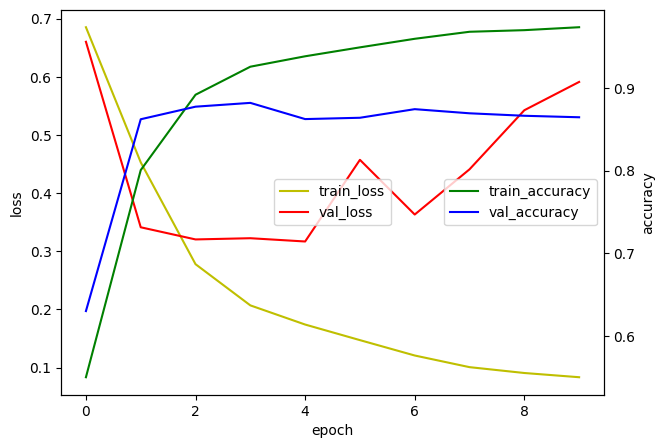

In [109]:
# 시각화 1
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(7,5))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['acc'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

In [47]:
# 테스트 데이터로 평가 1
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('test의 데이터 정확도: ', acc)

test의 데이터 정확도:  0.7781599760055542


1. pre 자르기, post 붙이기 : 0.7577599883079529
2. pre 자르기, pre 붙이기 : 0.7569199800491333
3. post 자르기, post 붙이기 : 0.7542799711227417
4. post 자르기, pre 붙이기 : 0.7525200247764587
- SKIP_TOP 20, DROPOUT 적용 후 : 0.7781599760055542

In [48]:
# 모델 저장
model.save('imdb_v2.10_skiptop20_lenght80.h5')

In [50]:
# 혼동행렬(교차표, 평가성능지표)
# y_test: 실제값
pred = model.predict(X_test)
y_hat = (pred>0.5).astype(int)
y_hat

782/782 [==============================] - 4s 5ms/step


array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [51]:
# 실제값(1d)과 예측값(2d)의 차원이 같지 않아도 됨
confusion_matrix(y_test, y_hat)

array([[9595, 2905],
       [2641, 9859]], dtype=int64)

In [52]:
# 실제값과 예측값의 차원이 모두 1차원이어야 함
pd.crosstab(y_test, y_hat.reshape(-1), rownames=['실제값'], colnames=['예측값']) 

예측값,0,1
실제값,,
0,9595,2905
1,2641,9859


In [54]:
# accuracy, precision, recall, f1_score
print('acc:', acc)
print('precision:', precision_score(y_test, y_hat))
print('recall:', recall_score(y_test, y_hat))
print('f1_score:', f1_score(y_test, y_hat))

acc: 0.7781599760055542
precision: 0.7724067690379192
recall: 0.78872
f1_score: 0.7804781507283091


# 12. 모델 사용하기

In [74]:
import re
review="""
Wicked for Good promised a continuation of the beloved story, yet the resulting film felt curiously deflated, struggling to recapture the potent magic of its predecessor. While the visual spectacle is undeniable—the costumes and set design are, at times, breathtaking—they often serve as a glittering distraction from a narrative that meanders without real purpose.
The core issue lies in the pacing and character arcs. The emotional stakes established so clearly before seem to have been exchanged for superficial grand gestures. Performances, while sincere, appear constrained by a script that leans too heavily on exposition and callbacks, rather than forging genuinely new ground. It’s particularly disappointing to see the complexity of the central friendship reduced to predictable emotional beats. Instead of soaring to new heights, the film remains grounded, offering competent but ultimately uninspired interpretations of themes we’ve seen explored far more compellingly.
The music, an essential component of this universe, lacks the soaring, memorable quality one anticipates. Several numbers feel oddly generic, failing to stick with you long after the credits roll. Wicked for Good is a perfectly adequate viewing experience, a film that checks all the necessary boxes without ever truly lighting up the screen. It is a production that respects the original material, perhaps too much, resulting in something safe, glossy, and, regrettably, a touch hollow. For a story about defying gravity, this sequel never quite manages to take flight.
""".lower()
review = re.sub('^a-zA-Z0-9\s', ' ', review)
review = review.split()
encoded = [1] + [word_to_id.get(r, -1) + 3 for r in review]
# SKIP_TOP 사용 (20>)
encoded = [item if (30<=item<10000) else 2 for item in encoded]
print(encoded)

[2, 2, 2, 52, 2, 2, 2, 2, 2, 2, 2, 246, 2, 2, 22, 421, 2, 2, 2, 2, 2, 2, 2, 2, 2, 94, 2, 137, 2, 2, 2, 2, 2, 2, 2, 270, 2, 2, 33, 2, 2, 400, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 209, 147, 2, 2, 2, 2, 2, 2, 2, 2, 2, 109, 2, 2, 921, 2, 2, 38, 695, 159, 306, 2, 28, 77, 2, 2, 2, 2, 2, 2, 137, 2, 977, 2, 34, 2, 229, 2, 2, 99, 2, 23, 2, 2, 2, 247, 74, 2, 2, 162, 2, 2, 572, 2, 2, 67, 2, 2, 2, 2, 2, 2, 2, 2, 727, 921, 2, 305, 2, 2, 2, 162, 2, 2, 22, 2, 2, 2, 2, 21, 2, 2, 2, 2, 2, 2, 110, 2, 230, 53, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 906, 489, 31, 2, 450, 2, 235, 2, 2, 2, 2, 2, 2, 25, 196, 103, 2, 898, 2, 2, 2, 52, 2, 2, 950, 2, 829, 2, 2, 22, 2, 2, 32, 2, 2, 2, 209, 126, 371, 2, 56, 2, 2, 2, 2, 2, 365, 2, 2, 2, 204, 2, 382, 99, 2, 2, 2, 142, 2, 2, 2, 2, 2, 2, 2, 2, 2, 65, 44, 2, 2, 2, 755, 115, 179, 2, 2, 193, 2, 2, 2, 2, 180, 2, 2, 2, 2, 2, 2, 2, 2, 148, 2, 2, 2, 2, 2, 33, 175, 2, 2, 2, 2, 2, 79, 171, 2, 2, 2, 68, 2, 2, 2, 131, 2, 2, 2, 734, 2, 2, 21, 34, 2, 2, 65, 2, 94, 2, 2, 2, 2, 94, 2, 2, 5

In [77]:
input_data = pad_sequences([encoded], 
                        maxlen=200, 
#                         truncating='pre', # 지정한 단어수(80) 이상일 경우 어디를 자를지
                        truncating='post',
                        padding='pre',
#                         padding='post' # 짧을 경우 앞/뒤에 zero를 붙임
                       )
input_data, len(input_data[0])

(array([[  0,   0,   0, ...,   2, 254,   2]]), 10000)

In [78]:
model.predict(input_data)

1/1 [==============================] - 0s 401ms/step


array([[0.810124]], dtype=float32)